# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline 

from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import r2_score


In [2]:
## Load the data into a DataFrame
iowa = pd.read_csv ('/Users/kristensu/downloads/Iowa_Liquor_sales_sample_10pct.csv')

In [3]:
iowa.head(3)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34


In [4]:
iowa.columns

Index([u'Date', u'Store Number', u'City', u'Zip Code', u'County Number',
       u'County', u'Category', u'Category Name', u'Vendor Number',
       u'Item Number', u'Item Description', u'Bottle Volume (ml)',
       u'State Bottle Cost', u'State Bottle Retail', u'Bottles Sold',
       u'Sale (Dollars)', u'Volume Sold (Liters)', u'Volume Sold (Gallons)'],
      dtype='object')

In [5]:
iowa.shape

(270955, 18)

# Clean Data

### Clean up column names

In [7]:
# Drop duplicate columns (cols that contain same info as another col)
iowa.drop(['County Number', 'Category', 'Item Number', 'Volume Sold (Gallons)'], axis=1, inplace=True)
iowa.columns

Index([u'Date', u'Store Number', u'City', u'Zip Code', u'County',
       u'Category Name', u'Vendor Number', u'Item Description',
       u'Bottle Volume (ml)', u'State Bottle Cost', u'State Bottle Retail',
       u'Bottles Sold', u'Sale (Dollars)', u'Volume Sold (Liters)'],
      dtype='object')

In [8]:
# Clean up column names 1: remove units of measurement
iowa.rename(columns = {'Bottle Volume (ml)': 'Bottle Volume', 'Sale (Dollars)': 'Sales', \
                      'Volume Sold (Liters)': 'Volume Sold'}, inplace=True)

# Clean up column names 2: convert all to lowercase letters
import string 
lower = string.ascii_lowercase
iowa.rename(columns = lambda x: x.lower(), inplace=True)

# Clean up column names 3: replace '', '(' and ')'
iowa.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

### Check and clean NaNs

In [9]:
iowa.isnull().sum()

date                      0
store_number              0
city                      0
zip_code                  0
county                 1077
category_name           632
vendor_number             0
item_description          0
bottle_volume             0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sales                     0
volume_sold               0
dtype: int64

In [22]:
# Try and map County NaNs by matching to City
iowa_county = pd.pivot_table(iowa, index=['city', 'county'], values=['sales'], aggfunc=(sum))
iowa_county.drop('sales', axis=1, inplace=True)

In [24]:
iowa_county.reset_index(inplace=True)

In [35]:
duplicate_county = 0
for x in iowa_county['city']:
    if iowa_county['city'].duplicated == True:
        duplicate_count += 1
duplicate_county

0

In [38]:
x = iowa_county['city'].duplicated()

In [40]:
duplicate_county = [i for i in x if i == True]

In [41]:
duplicate_county

[True, True, True, True, True, True, True, True, True, True, True]

### Clean values in columns with currency, zip_code and date

In [70]:
# Convert columns with dollar amounts from object to numeric float
currency = ['sales', 'state_bottle_cost', 'state_bottle_retail']
iowa[currency] = iowa[currency].apply(lambda x: x.str.replace('$', ''))
iowa[currency] = iowa[currency].apply(lambda x: pd.to_numeric(x))

# Convert zip_code from object to int
iowa['zip_code'] = pd.to_numeric(iowa['zip_code'], errors='coerce')
iowa= iowa.dropna()
iowa['zip_code'] = iowa.loc[:, ['zip_code']].astype(int)

# Convert date from object to datetime
iowa['date'] = pd.to_datetime(iowa['date'], format='%m/%d/%Y')
iowa['date'] = pd.to_datetime(iowa['date'], format='%m-%d-%Y')

In [71]:
iowa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269073 entries, 0 to 270954
Data columns (total 14 columns):
date                   269073 non-null datetime64[ns]
store_number           269073 non-null int64
city                   269073 non-null object
zip_code               269073 non-null int64
county                 269073 non-null object
category_name          269073 non-null object
vendor_number          269073 non-null int64
item_description       269073 non-null object
bottle_volume          269073 non-null int64
state_bottle_cost      269073 non-null float64
state_bottle_retail    269073 non-null float64
bottles_sold           269073 non-null int64
sales                  269073 non-null float64
volume_sold            269073 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(5), object(4)
memory usage: 30.8+ MB


In [75]:
#Assuming that none of the nans in the columns overlap, the percentage of nans in the iowa dataframe
total_na = sum(iowa.isnull().sum())
ratio_na = float(total_na)/(len(iowa.index.values))
print 'Percent of nans before drop: ', str(round(ratio_na*100,2)), '%' 

#Drop all nans since percentage of nans is small enough to be negligible
iowa.dropna(inplace=True)
print 'Total nans:'
print iowa.isnull().sum()
print 'Percent of nans after drop: ', str(round((float(sum(iowa.isnull().sum())*100)),2)), '%'

Percent of nans before drop:  0.0 %
Total nans:
date                   0
store_number           0
city                   0
zip_code               0
county                 0
category_name          0
vendor_number          0
item_description       0
bottle_volume          0
state_bottle_cost      0
state_bottle_retail    0
bottles_sold           0
sales                  0
volume_sold            0
dtype: int64
Percent of nans after drop:  0.0 %


In [13]:
iowa_df = pd.pivot_table(iowa, index=['county','store_number', 'item_description'], \
                         columns=None, values=['sales', 'volume_sold','bottles_sold'], aggfunc=np.sum)

In [14]:
iowa_df

bottles_sold  \
county store_number item_description                                            
Adair  3461         1800 Reposado Tequila                                   3   
                    Absolut Citron (lemon Vodka)                            7   
                    Absolut Raspberri                                       3   
                    Absolut Swedish Vodka 80 Prf                           24   
                    Admiral Nelson Spiced Rum                              17   
                    Ancient Age Bourbon                                     6   
                    Bacardi Superior Rum                                    8   
                    Barton Vodka                                           24   
                    Beefeater Gin                                           2   
                    Black Velvet                                          131   
                    Black Velvet Cinnamon Rush                              3   
                    Black Velvet Toasted Caramel                            3   
                    Canadian Ltd Whisky                                    36   
                    Canadian Reserve Whisky                                21   
                    Captain Morgan Original Spiced                          3   
                    Captain Morgan Spiced Rum                              29   
                    Chi-Chi's Margarita W/tequila                           8   
                    Christian Bros Brandy                                   8   
                    Crown Royal                                            12   
                    Crown Royal Canadian Whisky                             3   
                    Crown Royal Regal Apple                                 6   
                    Crystal Head Vodka                                      3   
                    Dekuyper Buttershots Schnapps                           3   
                    Dekuyper Hot Damn!                                      3   
                    Dekuyper Luscious Peachtree Schnapps                    8   
                    Dekuyper Peachtree Schnapps                             6   
                    Dekuyper Peachtree Schnapps Pet                         2   
                    Don Julio Reposado                                      2   
                    El Jimador Reposado Tequila                             2   
                    Evan Williams Str Bourbon                               3   
...                                                                       ...   
Wright 4515         Five O'clock Vodka                                     36   
                    Jim Beam                                               24   
                    Jose Cuervo Authentic Lime Margarita                    6   
                    Jose Cuervo Especial Reposado Flask                    24   
                    Jose Cuervo Especial Reposado Tequila                  24   
                    Mccormick Vodka Pet                                    24   
       4556         Admiral Nelson Spiced Rum                              24   
                    Black Velvet                                           36   
                    Black Velvet Toasted Caramel                           12   
                    Captain Morgan Original Spiced                         24   
                    Evan Williams Str Bourbon                              12   
                    Five O'clock PET Vodka                                 36   
                    Five O'clock Vodka                                     48   
                    Jim Beam                                               24   
                    Mccormick Vodka                                        48   
                    Mccormick Vodka Pet                                    24   
                    Seagrams 7 Crown Bl Whiskey                            24   
       4591    

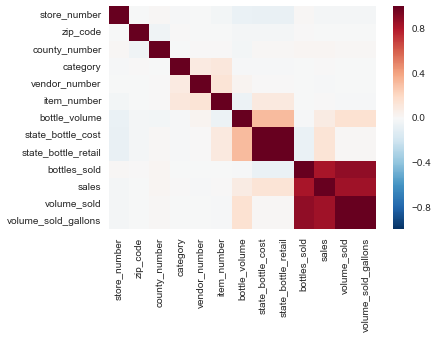

In [15]:
sns.heatmap(iowa.corr())

In [16]:
iowa_target = pd.DataFrame(iowa['sales'])

In [18]:
iowa_cols = []
for x in iowa:
    if iowa[x].dtype == float:
        iowa_cols.append(x)
    elif iowa[x].dtype == int:
        iowa_cols.append(x)
    else:
        pass

In [19]:
iowa_cols

['store_number',
 'zip_code',
 'county_number',
 'category',
 'vendor_number',
 'item_number',
 'bottle_volume',
 'state_bottle_cost',
 'state_bottle_retail',
 'bottles_sold',
 'sales',
 'volume_sold',
 'volume_sold_gallons']

In [20]:
iowa_df = iowa[iowa_cols]

In [21]:
iowa_df.drop('sales', axis=1, inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
X = iowa_df
y =  iowa_target

lr = linear_model.LinearRegression()
lr_model = lr.fit(X,y)

y_pred = lr_model.predict(iowa_df)
y_pred_df =  pd.DataFrame(y_pred)

ValueError: Argument dimensions are incompatible

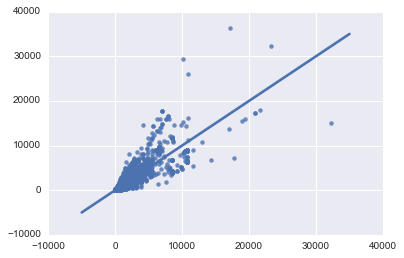

In [23]:
ax = sns.regplot(y_pred, y)
ax.figure.set_figheight(6)
ax.figure.set_figwidth(14)

ax.set_ylabel('Actual Values')
ax.set_xlabel('Predicted Values')
ax.set_title('Predicted vs. Actual Values');

In [153]:
lr_r2 =  r2_score(y_true=y, y_pred=y_pred)
lr_r2

0.77017501939506761

In [154]:
len(lr_model.coef_)

1

In [155]:
lr_model.coef_

array([[ -2.17204471e-03,  -1.82825396e-04,   5.84292343e-02,
          9.54960175e-05,  -1.90054507e-02,  -7.69417890e-05,
         -3.90405924e-02,   4.43882807e+01,  -2.33908950e+01,
          6.04164932e+00,   2.59660979e+02,  -9.56992665e+02]])

In [75]:
#df.groupby ( ‘key’ ) [ ‘ what to aggregate’ ].how_to_aggregate

store_sales = iowa.groupby(['store_number'])['sales'a].sum().to_frame()

In [76]:
store_sales

,sales
store_number,
2106,176517.45
2113,11376.12
2130,139440.02
2152,8625.74
2178,29912.68
2190,153492.12
2191,172431.69
2200,26986.42
2205,24623.01


In [69]:
iowa['bottle_volume'].unique()

array([ 750, 1000, 1750,  200,  300,  500,  375, 3000, 2400,  600,  100,
       1200,  800, 4800,  150, 2250,  400, 3600,   50,  850,  950,  603,
       2550, 1125, 6000, 4500,  900,  250, 1500])

In [ ]:
{'vodka': }
#vodka
#schnapps
#whiskey
#rum
#scotch
#gin
#liqueurs
#brandies
#tequila
#beer
#other


In [63]:
iowa['category_name'].nunique()

71

In [23]:
iowa['date'].dtypes

dtype('O')

In [24]:
## Transform the dates if needed, e.g.
iowa['date'] = iowa['date'].str.replace('/','-') 
iowa['date'] = pd.to_datetime(iowa['date'], format= '%m-%d-%Y')

In [29]:
# Check for null or other weird values
iowa.isnull().sum()

date                      0
store_number              0
city                      0
zip_code                  0
county_number          1077
county                 1077
category                 68
category_name           632
vendor_number             0
item_number               0
item_description          0
bottle_volume             0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sales                     0
volume_sold               0
volume_sold_gallons       0
dtype: int64

In [ ]:
iowa.dtypes

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
len(iowa['County'].value_counts())

In [ ]:
iowa_county = pd.pivot_table(iowa, index=iowa['County'], values=['Sale (Dollars)'])
iowa_county.head()

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [ ]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.